<a href="https://colab.research.google.com/github/pranay8297/BitcoinSummaryGeneration/blob/main/cryptonite_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
import torch

from facenet_pytorch import MTCNN, InceptionResnetV1

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import AdamW

from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
mtcnn = MTCNN()
# device = torch.device('mps')
device = torch.device('cpu')
print(f'Running on device: {device}')
# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2', device = device).eval()

Running on device: mps


In [ ]:
# verification of device
list(resnet.parameters())[0].data.device

device(type='mps', index=0)

# Basic Regression

In [ ]:


path = Path('../part3_faces')
items = list(path.iterdir())

class FaceDS(Dataset):
    def __init__(self, image_paths: list[Path]):

        self.image_paths = image_paths
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self.to_tensor(Image.open(self.image_paths[idx]))
        name = self.image_paths[idx].name
        age = float(name.split('.')[0].split('_')[0])
        return img, age

train_items, valid_items = train_test_split(items, test_size = 0.15)
train_ds, valid_ds = FaceDS(train_items), FaceDS(valid_items)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)


# Create a data augmentation pipeline here
# Create a data augmentation pipeline,
    # warping images,
    # tilting them,
    # increase and decrease brightness,
    # add some noise,
    # increase and decrease contrast

from torchvision.transforms import v2

data_aug_pipeline = v2.Compose([
    v2.RandomPerspective(distortion_scale=0.4, p=0.4),
    v2.RandomRotation(degrees=(0, 10)),
    v2.RandomAdjustSharpness(sharpness_factor=2),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 0.4)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = torch.Tensor([0.485, 0.456, 0.406]), std = torch.Tensor([0.229, 0.224, 0.225]).sqrt()),
])


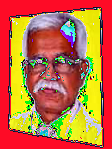

In [ ]:
batch = next(iter(train_dl))
transformed_batch = data_aug_pipeline(batch[0])
transforms.ToPILImage()(transformed_batch[1])

In [ ]:
from torch import nn

class AgeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = InceptionResnetV1(pretrained='vggface2', device = device)
        self.final_layers = nn.Sequential(
            nn.Linear(512, 256, device = device),
            nn.ReLU(),
            nn.Linear(256, 128, device = device),
            nn.ReLU(),
            nn.Linear(128, 1, device = device)
        )

        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        embs = self.resnet(x)
        return self.final_layers(embs)

from tqdm import tqdm

def mae(model, valid_dl):

    pipe = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean = torch.Tensor([0.485, 0.456, 0.406]), std = torch.Tensor([0.229, 0.224, 0.225]).sqrt()),
    ])
    diffs = []
    for batch in tqdm(valid_dl):
        with torch.no_grad():
            x, y = batch
            x = pipe(x)
            x = x.to(device)
            y = y.to(torch.float32).to(device)
            out = model(x)
            diff = (out.squeeze() - y).abs()
            diffs.append(diff)
    return torch.cat(diffs).mean().item()

In [ ]:
from torch.optim import AdamW
from torch.nn import functional as F

epochs = 3

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

model = AgeModel()
opt = AdamW(model.parameters(), lr = 1e-03, weight_decay = 0)

max_lr = 5e-03
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.2,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.85,
                                                   max_momentum=0.95,
                                                   div_factor=25.0,
                                                   final_div_factor=200,
                                                   last_epoch=-1)

for epoch in range(epochs):
    train_iter = iter(train_dl)
    for it, (x, y) in enumerate(train_iter):
        x = data_aug_pipeline(x)
        x = x.to(device)
        y = y.to(torch.float32).to(device)
        out = model(x)
        loss = F.mse_loss(out.squeeze(), y)

        if it%5 == 0:
            print(f"it: {it}, loss: {loss.item():.4f}")

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

it: 0, loss: 2130.1230
it: 5, loss: 2048.7388
it: 10, loss: 1758.9016
it: 15, loss: 1862.6320
it: 20, loss: 1317.7058
it: 0, loss: 706.6468
it: 5, loss: 599.1984
it: 10, loss: 260.4877
it: 15, loss: 183.2344
it: 20, loss: 288.3316
it: 0, loss: 185.5305
it: 5, loss: 119.0242
it: 10, loss: 252.9739
it: 15, loss: 113.9711
it: 20, loss: 257.6254


In [ ]:
from torch.optim import AdamW
from torch.nn import functional as F

epochs = 20

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

# model = AgeModel()

# unfreeze the model
for param in model.resnet.parameters():
    param.requires_grad = True

opt = AdamW(model.parameters(), lr = 1e-03, weight_decay = 0.8)

max_lr = 5e-04
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.2,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.85,
                                                   max_momentum=0.98,
                                                   div_factor=25,
                                                   final_div_factor=1000,
                                                   last_epoch=-1)

for epoch in range(epochs):
    train_iter = iter(train_dl)
    for it, (x, y) in enumerate(train_iter):
        x = data_aug_pipeline(x)
        x = x.to(device)
        y = y.to(torch.float32).to(device)
        out = model(x)
        loss = F.mse_loss(out.squeeze(), y)

        if it%5 == 0:
            print(f"epoch: {epoch}, it: {it}, loss: {loss.item():.4f}")

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    print(f"epoch: {epoch}, VALID MAE: {mae(model, valid_dl)}")

epoch: 0, it: 0, loss: 141.9089
epoch: 0, it: 5, loss: 231.1313
epoch: 0, it: 10, loss: 162.5414
epoch: 0, it: 15, loss: 158.9531
epoch: 0, it: 20, loss: 161.1090
epoch: 0, it: 25, loss: 136.4806
epoch: 0, it: 30, loss: 108.1954
epoch: 0, it: 35, loss: 301.1512
epoch: 0, it: 40, loss: 174.9536
epoch: 0, it: 45, loss: 92.5636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.68it/s]


epoch: 0, VALID MAE: 7.936769962310791
epoch: 1, it: 0, loss: 101.0490
epoch: 1, it: 5, loss: 70.0298
epoch: 1, it: 10, loss: 46.4441
epoch: 1, it: 15, loss: 131.2519
epoch: 1, it: 20, loss: 59.0328
epoch: 1, it: 25, loss: 80.5452
epoch: 1, it: 30, loss: 110.9138
epoch: 1, it: 35, loss: 63.7274
epoch: 1, it: 40, loss: 175.3600
epoch: 1, it: 45, loss: 105.3716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.81it/s]


epoch: 1, VALID MAE: 7.689247131347656
epoch: 2, it: 0, loss: 60.2660
epoch: 2, it: 5, loss: 48.1547
epoch: 2, it: 10, loss: 96.9688
epoch: 2, it: 15, loss: 131.3954
epoch: 2, it: 20, loss: 101.7822
epoch: 2, it: 25, loss: 127.5529
epoch: 2, it: 30, loss: 180.5276
epoch: 2, it: 35, loss: 147.5617
epoch: 2, it: 40, loss: 133.3130
epoch: 2, it: 45, loss: 85.8532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.82it/s]


epoch: 2, VALID MAE: 7.873596668243408
epoch: 3, it: 0, loss: 76.2719
epoch: 3, it: 5, loss: 88.7589
epoch: 3, it: 10, loss: 131.0746
epoch: 3, it: 15, loss: 106.1798
epoch: 3, it: 20, loss: 54.3662
epoch: 3, it: 25, loss: 59.4625
epoch: 3, it: 30, loss: 129.1148
epoch: 3, it: 35, loss: 98.7058
epoch: 3, it: 40, loss: 99.9863
epoch: 3, it: 45, loss: 83.3286


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.83it/s]


epoch: 3, VALID MAE: 7.682510852813721
epoch: 4, it: 0, loss: 63.4805
epoch: 4, it: 5, loss: 111.3621
epoch: 4, it: 10, loss: 81.0830
epoch: 4, it: 15, loss: 88.9243
epoch: 4, it: 20, loss: 75.0407
epoch: 4, it: 25, loss: 132.6740
epoch: 4, it: 30, loss: 110.9152
epoch: 4, it: 35, loss: 98.0347
epoch: 4, it: 40, loss: 114.5465
epoch: 4, it: 45, loss: 123.3925


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.23it/s]


epoch: 4, VALID MAE: 7.827737808227539
epoch: 5, it: 0, loss: 58.3731
epoch: 5, it: 5, loss: 84.5105
epoch: 5, it: 10, loss: 51.2969
epoch: 5, it: 15, loss: 71.5135
epoch: 5, it: 20, loss: 33.8581
epoch: 5, it: 25, loss: 69.4859
epoch: 5, it: 30, loss: 74.6670
epoch: 5, it: 35, loss: 81.5545
epoch: 5, it: 40, loss: 64.4885
epoch: 5, it: 45, loss: 102.6450


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 11.67it/s]


epoch: 5, VALID MAE: 7.3715643882751465
epoch: 6, it: 0, loss: 43.0266
epoch: 6, it: 5, loss: 35.8522
epoch: 6, it: 10, loss: 62.0299
epoch: 6, it: 15, loss: 57.9012
epoch: 6, it: 20, loss: 46.2398
epoch: 6, it: 25, loss: 26.2087
epoch: 6, it: 30, loss: 71.6432
epoch: 6, it: 35, loss: 67.9371
epoch: 6, it: 40, loss: 86.7133
epoch: 6, it: 45, loss: 128.9288


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.75it/s]


epoch: 6, VALID MAE: 7.428619384765625
epoch: 7, it: 0, loss: 44.3646
epoch: 7, it: 5, loss: 71.2890
epoch: 7, it: 10, loss: 115.0059
epoch: 7, it: 15, loss: 93.0442
epoch: 7, it: 20, loss: 56.5311
epoch: 7, it: 25, loss: 69.7152
epoch: 7, it: 30, loss: 50.8508
epoch: 7, it: 35, loss: 56.1918
epoch: 7, it: 40, loss: 73.0223
epoch: 7, it: 45, loss: 53.2842


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.88it/s]


epoch: 7, VALID MAE: 7.283822059631348
epoch: 8, it: 0, loss: 32.9182
epoch: 8, it: 5, loss: 46.9000
epoch: 8, it: 10, loss: 62.3616
epoch: 8, it: 15, loss: 86.1086
epoch: 8, it: 20, loss: 79.7707
epoch: 8, it: 25, loss: 48.5317
epoch: 8, it: 30, loss: 31.5503
epoch: 8, it: 35, loss: 97.8712
epoch: 8, it: 40, loss: 53.7870
epoch: 8, it: 45, loss: 42.6677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.05it/s]


epoch: 8, VALID MAE: 6.875927448272705
epoch: 9, it: 0, loss: 38.8334
epoch: 9, it: 5, loss: 98.9147
epoch: 9, it: 10, loss: 90.6739
epoch: 9, it: 15, loss: 107.4546
epoch: 9, it: 20, loss: 31.7993
epoch: 9, it: 25, loss: 53.7913
epoch: 9, it: 30, loss: 57.7192
epoch: 9, it: 35, loss: 48.7123
epoch: 9, it: 40, loss: 41.9780
epoch: 9, it: 45, loss: 30.2514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.68it/s]


epoch: 9, VALID MAE: 6.749334335327148
epoch: 10, it: 0, loss: 72.7943
epoch: 10, it: 5, loss: 69.1338
epoch: 10, it: 10, loss: 40.7221
epoch: 10, it: 15, loss: 31.1977
epoch: 10, it: 20, loss: 36.4113
epoch: 10, it: 25, loss: 53.2599
epoch: 10, it: 30, loss: 40.0557
epoch: 10, it: 35, loss: 46.2629
epoch: 10, it: 40, loss: 57.7308
epoch: 10, it: 45, loss: 43.0025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.08it/s]


epoch: 10, VALID MAE: 6.853792667388916
epoch: 11, it: 0, loss: 38.3108
epoch: 11, it: 5, loss: 59.7159
epoch: 11, it: 10, loss: 42.9168
epoch: 11, it: 15, loss: 87.9398
epoch: 11, it: 20, loss: 42.0869
epoch: 11, it: 25, loss: 43.9422
epoch: 11, it: 30, loss: 52.5808
epoch: 11, it: 35, loss: 38.4088
epoch: 11, it: 40, loss: 47.4664
epoch: 11, it: 45, loss: 35.4034


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 11.87it/s]


epoch: 11, VALID MAE: 6.711455345153809
epoch: 12, it: 0, loss: 48.8531
epoch: 12, it: 5, loss: 51.7406
epoch: 12, it: 10, loss: 39.7049
epoch: 12, it: 15, loss: 36.3337
epoch: 12, it: 20, loss: 57.0998
epoch: 12, it: 25, loss: 154.1787
epoch: 12, it: 30, loss: 46.1359
epoch: 12, it: 35, loss: 34.2378
epoch: 12, it: 40, loss: 26.6074
epoch: 12, it: 45, loss: 22.7964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.05it/s]


epoch: 12, VALID MAE: 6.820837020874023
epoch: 13, it: 0, loss: 39.6341
epoch: 13, it: 5, loss: 53.9428
epoch: 13, it: 10, loss: 50.0556
epoch: 13, it: 15, loss: 12.3890
epoch: 13, it: 20, loss: 44.3275
epoch: 13, it: 25, loss: 56.5473
epoch: 13, it: 30, loss: 14.3051
epoch: 13, it: 35, loss: 20.7722
epoch: 13, it: 40, loss: 16.6192
epoch: 13, it: 45, loss: 19.8468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.59it/s]


epoch: 13, VALID MAE: 6.777617454528809
epoch: 14, it: 0, loss: 61.4282
epoch: 14, it: 5, loss: 17.5567
epoch: 14, it: 10, loss: 23.4225
epoch: 14, it: 15, loss: 23.9463
epoch: 14, it: 20, loss: 31.7122
epoch: 14, it: 25, loss: 28.9699
epoch: 14, it: 30, loss: 20.6348
epoch: 14, it: 35, loss: 17.1786
epoch: 14, it: 40, loss: 27.2730
epoch: 14, it: 45, loss: 40.0829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.56it/s]


epoch: 14, VALID MAE: 6.645547866821289
epoch: 15, it: 0, loss: 19.1913
epoch: 15, it: 5, loss: 14.1688
epoch: 15, it: 10, loss: 12.5815
epoch: 15, it: 15, loss: 13.3316
epoch: 15, it: 20, loss: 16.8803
epoch: 15, it: 25, loss: 12.6975
epoch: 15, it: 30, loss: 28.8493
epoch: 15, it: 35, loss: 31.3711
epoch: 15, it: 40, loss: 26.3575
epoch: 15, it: 45, loss: 17.1601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 14.01it/s]


epoch: 15, VALID MAE: 6.82863712310791
epoch: 16, it: 0, loss: 28.4832
epoch: 16, it: 5, loss: 36.5087
epoch: 16, it: 10, loss: 23.9063
epoch: 16, it: 15, loss: 12.4141
epoch: 16, it: 20, loss: 25.5822
epoch: 16, it: 25, loss: 12.3150
epoch: 16, it: 30, loss: 27.4394
epoch: 16, it: 35, loss: 17.6844
epoch: 16, it: 40, loss: 9.1913
epoch: 16, it: 45, loss: 11.2519


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 13.89it/s]


epoch: 16, VALID MAE: 6.697254180908203
epoch: 17, it: 0, loss: 11.7285
epoch: 17, it: 5, loss: 10.8761
epoch: 17, it: 10, loss: 29.5040
epoch: 17, it: 15, loss: 24.6964
epoch: 17, it: 20, loss: 21.1448
epoch: 17, it: 25, loss: 7.9247
epoch: 17, it: 30, loss: 36.6212
epoch: 17, it: 35, loss: 14.3905
epoch: 17, it: 40, loss: 37.8442
epoch: 17, it: 45, loss: 7.6295


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.02it/s]


epoch: 17, VALID MAE: 6.578970432281494
epoch: 18, it: 0, loss: 11.8167
epoch: 18, it: 5, loss: 21.8766
epoch: 18, it: 10, loss: 19.3703
epoch: 18, it: 15, loss: 38.0298
epoch: 18, it: 20, loss: 23.7881
epoch: 18, it: 25, loss: 16.0718
epoch: 18, it: 30, loss: 31.6954
epoch: 18, it: 35, loss: 27.0136
epoch: 18, it: 40, loss: 14.3132
epoch: 18, it: 45, loss: 24.4471


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 13.05it/s]


epoch: 18, VALID MAE: 6.662151336669922
epoch: 19, it: 0, loss: 38.3712
epoch: 19, it: 5, loss: 10.7372
epoch: 19, it: 10, loss: 44.4562
epoch: 19, it: 15, loss: 21.4509
epoch: 19, it: 20, loss: 24.2102
epoch: 19, it: 25, loss: 36.2273
epoch: 19, it: 30, loss: 29.0559
epoch: 19, it: 35, loss: 29.2417
epoch: 19, it: 40, loss: 12.3157
epoch: 19, it: 45, loss: 27.6660


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.25it/s]

epoch: 19, VALID MAE: 6.683879375457764


In [ ]:


mae(model, valid_dl)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.19it/s]


6.499332904815674

# Experimenting with Embedding Space - TODO



1.   Checking POC, on KL Divergence Loss works or not
2.   Preparing the dataset
3.   Create a CSV and over fit it



In [ ]:
print('SHIT')

## 1. Checking POC, on KL Divergence Loss works or not - **IT WORKS!**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
mu_pred = torch.randn(100, 64)
log_var_pred = torch.randn(100, 64)

mu_pred.requires_grad = True
log_var_pred.requires_grad = True

lr = 5e-02

Mu_target = torch.linspace(-0.9, 0.9, 100)
Var_target = torch.ones_like(Mu_target) * 0.5



for i in range(10000):
# Compute KL Divergence
    kl_div = 0.5 * (
        (torch.log(Var_target.unsqueeze(1)) - log_var_pred) +
        (torch.exp(log_var_pred) + (mu_pred - Mu_target.unsqueeze(1))**2) / Var_target.unsqueeze(1) -
        1.0
    )

    loss = kl_div.sum(dim=1).mean()
    loss.backward()
    if i%200 == 0:
        print(f"Iter: {i}, loss: {loss.item()}")

    # Optimization Step
    with torch.no_grad():
        mu_pred += -lr*mu_pred.grad
        log_var_pred += -lr*log_var_pred.grad

        mu_pred.grad.zero_()
        log_var_pred.grad.zero_()

Iter: 0, loss: 132.49314880371094
Iter: 200, loss: 85.4301528930664
Iter: 400, loss: 58.758079528808594
Iter: 600, loss: 41.544532775878906
Iter: 800, loss: 30.004776000976562
Iter: 1000, loss: 22.104738235473633
Iter: 1200, loss: 16.609539031982422
Iter: 1400, loss: 12.730925559997559
Iter: 1600, loss: 9.952766418457031
Iter: 1800, loss: 7.931848526000977
Iter: 2000, loss: 6.4374847412109375
Iter: 2200, loss: 5.313256740570068
Iter: 2400, loss: 4.452266216278076
Iter: 2600, loss: 3.7808878421783447
Iter: 2800, loss: 3.2479937076568604
Iter: 3000, loss: 2.817763090133667
Iter: 3200, loss: 2.4648516178131104
Iter: 3400, loss: 2.1711325645446777
Iter: 3600, loss: 1.9234857559204102
Iter: 3800, loss: 1.7122900485992432
Iter: 4000, loss: 1.5303906202316284
Iter: 4200, loss: 1.3723889589309692
Iter: 4400, loss: 1.2341492176055908
Iter: 4600, loss: 1.1124542951583862
Iter: 4800, loss: 1.0047640800476074
Iter: 5000, loss: 0.909043550491333
Iter: 5200, loss: 0.8236410617828369
Iter: 5400, loss

(100, 64)


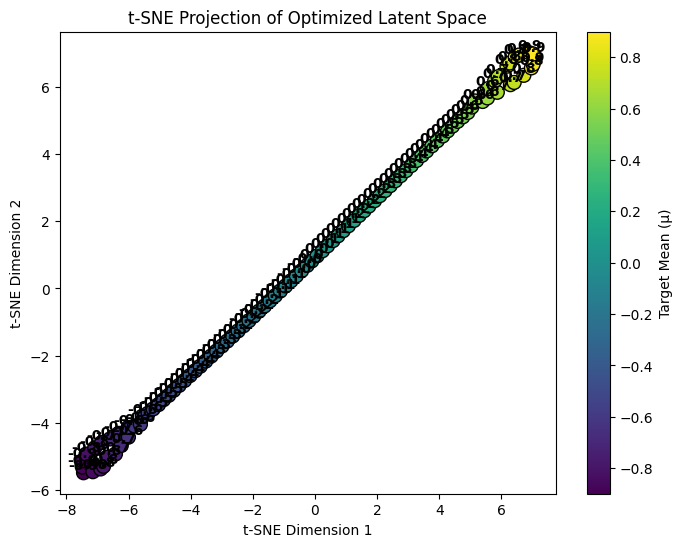

In [ ]:


# Convert optimized latents to numpy arrays
mu_np = mu_pred.detach().numpy()
targets_np = Mu_target.numpy()

# Apply t-SNE for 2D projection
print(mu_np.shape)
tsne = TSNE(n_components=2, random_state=42, perplexity = 25)
latent_2d = tsne.fit_transform(mu_np)

# Create plot with color coding by target means
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=targets_np, cmap='viridis',
                      s=100, edgecolor='black')

# Add labels and colorbar
plt.colorbar(scatter, label='Target Mean (μ)')
plt.title('t-SNE Projection of Optimized Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Annotate points with their target means
for i, (x, y) in enumerate(latent_2d):
    plt.text(x, y, f'{targets_np[i]:.1f}',
             ha='center', va='bottom', fontweight='bold')

plt.show()

## 2. Lets Prepare a sample DATASET for POC

In [ ]:
# Lets extract embeddings for a face
path = Path("/Users/pranaybindela/Desktop/sd/cryptonite/agedb_subset")
len(list(path.iterdir()))


266

In [ ]:
'''
pipeline:
1. get images
    1.1. Preprocess Images - Convert black and white to color, - Resize and store and do
        check what kind of preprocessing is required for facenet model
    1.2. Normalize images using mean and variance specified above
    1.3. Convert all images to tensors
2. get corrosponding ages
3. get embeddings
4. Store it in CSV file - embedding, f_path, age
'''



'\npipeline: \n1. get images\n    1.1. Preprocess Images - Convert black and white to color, - Resize and store and do \n        check what kind of preprocessing is required for facenet model\n    1.2. Normalize images using mean and variance specified above\n    1.3. Convert all images to tensors\n2. get corrosponding ages\n3. get embeddings\n4. Store it in CSV file - embedding, f_path, age\n'

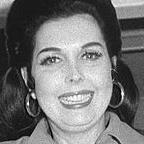

In [ ]:
img = Image.open(path/'15027_AnnMiller_53_f.jpg')
img

In [ ]:
out = transforms.ToTensor()(img)
out.shape

torch.Size([3, 144, 144])

In [ ]:
import numpy as np
import cv2

def is_grayscale_image(img):
    """
    Check if an image is effectively grayscale despite having 3 channels.
    Args:
        img: numpy array of shape (H, W, 3) or (3, H, W)
    Returns:
        bool: True if image is grayscale
    """
    # Handle both channel first and channel last formats
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))

    # Convert to float for precise comparison
    img_float = img.astype(float)

    # Check if all channels are equal (within small tolerance for jpeg artifacts)
    return np.allclose(img_float[:,:,0], img_float[:,:,1], atol=2.0) and \
           np.allclose(img_float[:,:,1], img_float[:,:,2], atol=2.0)

is_grayscale_image(out.numpy())

True

In [ ]:
img = Image.open(path/"2518_DonJohnson_45_m.jpg")
gray_transform = transforms.Grayscale(num_output_channels=3)

# Apply the transform
gray_three = gray_transform(img)

img_t = transforms.ToTensor()(img)
img_t_g = transforms.ToTensor()(gray_three)

In [ ]:
def facenet_preprocess(image_tensor: torch.Tensor) -> torch.Tensor:

    # image_tensor.shape = (3, height, width)

    # resize the image to 160, 160
    # normalize the image using mean = torch.Tensor([0.485, 0.456, 0.406]), std = torch.Tensor([0.229, 0.224, 0.225]).sqrt()
    # write the code below
    image_tensor = image_tensor.float()

    # Step 1: Resize the image to 160x160.
    # F.interpolate expects a 4D tensor (N, C, H, W), so add a batch dimension.
    image_tensor = image_tensor.unsqueeze(0)  # now shape is (1, 3, H, W)
    image_tensor = F.interpolate(image_tensor, size=(160, 160), mode='bilinear', align_corners=False)
    image_tensor = image_tensor.squeeze(0)      # back to (3, 160, 160)

    # Step 2: Normalize the image.
    # Note: The provided normalization uses std values after applying .sqrt() on them.
    mean = torch.tensor([0.485, 0.456, 0.406], device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=image_tensor.device).sqrt().view(3, 1, 1)

    image_tensor = (image_tensor - mean) / std

    return image_tensor


In [ ]:
inputs = [facenet_preprocess(img_t), facenet_preprocess(img_t_g)]
x = torch.stack(inputs)
x.shape

torch.Size([2, 3, 160, 160])

In [ ]:
device = torch.device('mps')
x = x.to(device)
resnet = InceptionResnetV1(pretrained='vggface2', device = device).eval()
with torch.no_grad():
    embs = resnet(x)

In [ ]:
with torch.no_grad():
    mse = F.mse_loss(embs[0], embs[1])
print(mse)

tensor(0.0002, device='mps:0')


In [ ]:
int(pat.name.split('.')[0].split('_')[-2])

51

In [ ]:
image_tensors = []
ages = []
for pat in path.iterdir():
    img = Image.open(pat)
    img_t = transforms.ToTensor()(img)
    img_t = facenet_preprocess(img_t)
    image_tensors.append(img_t)
    ages.append(int(pat.name.split('.')[0].split('_')[-2]))

image_tensors = image_tensors[:256]

image_tensors = torch.stack(image_tensors)
image_tensors.shape

torch.Size([256, 3, 160, 160])

In [ ]:
batches = image_tensors.chunk(4, dim = 0)
batches[0].shape

torch.Size([64, 3, 160, 160])

In [ ]:
batch_embs = []
for batch in batches:
    with torch.no_grad():
        batch = batch.to(device)
        embs = resnet(batch)
        batch_embs.append(embs.detach())

In [ ]:
batch_embs[0].shape

torch.Size([64, 512])

In [ ]:
all_embs = torch.cat(batch_embs)
all_embs.shape

torch.Size([256, 512])

In [ ]:
np_embs = all_embs.cpu().numpy()

In [ ]:
2 in range(1, 4)

True

In [ ]:
bins = {
    range(1, 4): 0,
    range(4, 8): 1,
    range(8, 13): 2,
    range(13, 17): 3,
    range(18, 21): 4,
    range(21, 27): 5,
    range(27, 35): 6,
    range(35, 300): 7,
}

df_data = []

pats = list(path.iterdir())[:256]
for p, np_em, age in zip(pats, np_embs, ages):
    tmp = {'emb': np_em, 'image_path': p, 'age': age}
    for k, v in bins.items():
        if age in k:
            tmp['bin'] = v
    df_data.append(tmp)

# convert the list of dicts to pandas dataframe
df = pd.DataFrame(df_data)
df.head()

,emb,image_path,age,bin
0,"[0.017245019, -0.037073854, 0.040230718, 0.000...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,45,7.0
1,"[0.033666894, 0.032769732, 0.10764718, -0.0228...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,19,4.0
2,"[0.015804894, 0.059820503, 0.019769227, -0.014...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,36,7.0
3,"[-0.021220405, 0.037600096, 0.039487164, -0.04...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,43,7.0
4,"[-0.00014935217, -0.064555846, 0.027074384, -0...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,48,7.0


In [ ]:
# Save DF
df.to_csv('/Users/pranaybindela/Desktop/sd/cryptonite/age_subset_embeddings.csv', index = False)

In [ ]:
df.dropna(inplace = True)

In [ ]:

X = df['emb'].values
Y = df['bin'].values

X = np.stack(X)

In [ ]:
X.shape, Y.shape

((249, 512), (249,))

(100, 64)


IndexError: index 100 is out of bounds for axis 0 with size 100

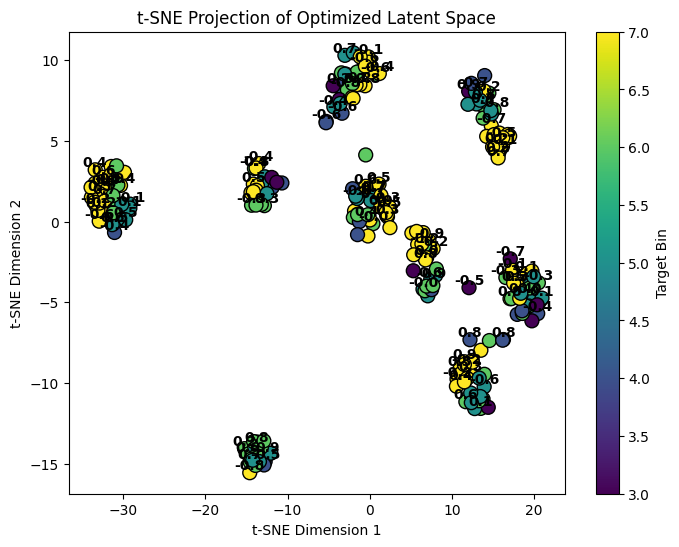

In [ ]:
# Ok, lets do t-SNE between emb column and bin column
from sklearn.manifold import TSNE

# Convert optimized latents to numpy arrays
mu_np = mu_pred.detach().numpy()
targets_np = Mu_target.numpy()

# Apply t-SNE for 2D projection
print(mu_np.shape)
tsne = TSNE(n_components=2, random_state=42, perplexity = 25)
latent_2d = tsne.fit_transform(X)

# Create plot with color coding by target means
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=Y, cmap='viridis',
                      s=100, edgecolor='black')

# Add labels and colorbar
plt.colorbar(scatter, label='Target Bin')
plt.title('t-SNE Projection of Optimized Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Annotate points with their target means
for i, (x, y) in enumerate(latent_2d):
    plt.text(x, y, f'{targets_np[i]:.1f}',
             ha='center', va='bottom', fontweight='bold')

plt.show()

In [ ]:
df

,emb,image_path,age,bin
0,"[0.017245019, -0.037073854, 0.040230718, 0.000...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,45,7.0
1,"[0.033666894, 0.032769732, 0.10764718, -0.0228...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,19,4.0
2,"[0.015804894, 0.059820503, 0.019769227, -0.014...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,36,7.0
3,"[-0.021220405, 0.037600096, 0.039487164, -0.04...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,43,7.0
4,"[-0.00014935217, -0.064555846, 0.027074384, -0...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,48,7.0
...,...,...,...,...
251,"[0.0305247, -0.0016192339, 0.03173077, -0.0298...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,39,7.0
252,"[-0.01132542, 0.022351617, 0.016266132, -0.034...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,54,7.0
253,"[-0.09678229, 0.08355287, 0.08224749, 0.043266...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,24,5.0
254,"[0.057890885, 0.0404021, 0.018301817, -0.00467...",/Users/pranaybindela/Desktop/sd/cryptonite/age...,39,7.0


## Lets Implement the model - POC - Showing promising results

In [ ]:
class EmbDS(Dataset):

    def __init__(self, df, means = []):
        '''
            [
                (1, 4),    # Early childhood -> 0 -> -0.9
                (4, 8),    # Middle childhood -> 1 -> -0.5
                (8, 13),   # Pre-teen -> 2 -> -0.25
                (13, 18),  # Teen -> 3 -> 0.0
                (18, 21),  # Critical age threshold -> 0.3
                (21, 27),  # Young adult -> 0.6
                (27, 35),  # Early middle adult -> 0.75
                (35, 100)  # Older adult -> 0.95
            ]
        '''
        self.means = [-0.9, -0.5, -0.25, 0.0, 0.3, 0.6, 0.75, 0.95] if means == [] else means
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        bin_id = int(row['bin'])
        emb = torch.Tensor(row['emb'])
        return emb, self.means[bin_id]


In [ ]:
df_shuffled = df.sample(frac=1, random_state=42)

# Calculate the split index:
# Let N be the total number of samples. We want T = N/1.1 (training)
train_size = int(len(df_shuffled) / 1.1)  # equivalent to int(len(df_shuffled)*10/11)
print(train_size)
# Split the DataFrame
train_df = df_shuffled.iloc[:train_size]
valid_df = df_shuffled.iloc[train_size:]

226


In [ ]:
train_ds = EmbDS(train_df)
valid_ds = EmbDS(valid_df)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

train_iter = iter(train_dl)
batch = next(train_iter)

batch[0].shape, batch[1].shape

(torch.Size([32, 512]), torch.Size([32]))

In [ ]:
def KLDivergenceLoss(mu, log_var, target_mu, target_var = torch.Tensor([0.5])):
    target_var = target_var.to(mu.device)
    kl_div = 0.5 * (
        (torch.log(target_var.unsqueeze(1)) - log_var) +
        (torch.exp(log_var) + (mu - target_mu.unsqueeze(1))**2) / target_var.unsqueeze(1) -
        1.0
    )

    loss = kl_div.sum(dim=1).mean()
    return loss

# KLDivergenceLoss(batch[0][:, :256], batch[0][:, 256:], batch[1], torch.Tensor([0.5]))

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    def __init__(self, input_dim, output_dim, norm = False):
        super().__init__()

        layers = []
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        layers.append(nn.ReLU())
        layers.append(nn.Linear(input_dim, output_dim))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class IDBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        if input_dim != output_dim:
            self.down_lin = nn.Linear(input_dim, output_dim)
        else:
            self.down_lin = None

    def forward(self, x):
        if self.down_lin:
            return self.down_lin(x)
        else:
            return x


class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm = False):
        super().__init__()
        self.down_lin = IDBlock(input_dim, output_dim)
        self.b1 = PreActBlock(output_dim, output_dim, norm = norm)
        self.b2 = PreActBlock(output_dim, output_dim, norm = norm)

    def forward(self, x):
        down = self.down_lin(x)
        out = self.b1(down)
        out = self.b2(out)
        return down + out

class EmbTransform(nn.Module):
    def __init__(self):
        super(EmbTransform, self).__init__()
        self.l1 = ResBlock(512, 256, norm = True)
        self.l2 = ResBlock(256, 256, norm = True)
        self.l3 = ResBlock(256, 128, norm = True)
        self.l4 = PreActBlock(128, 128, norm = False)
        self.l5 = PreActBlock(128, 128, norm = False)

    def forward(self, x):
        breakpoint()
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        mu, log_var = x[:, :64], x[:, 64:]
        return mu, log_var

In [ ]:
x, y = batch
model = EmbTransform()
model.to(device)

for i in range(10):
    x = x.to(device)
    y = y.to(torch.float32).to(device)
    mu, log_var = model(x)

    loss = KLDivergenceLoss(mu, log_var, y)
    print(loss.item())
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param.data += -0.01 * param.grad
            param.grad.data = torch.zeros_like(param.grad.data)

51.21188735961914
42.712852478027344
28.021188735961914
10.021280288696289
9.82590103149414
25.25547981262207
47.247894287109375
44.11692810058594
40.35381317138672
34.890811920166016


In [ ]:
from torch.optim import AdamW
from torch.nn import functional as F

epochs = 100

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

model = EmbTransform()

device = torch.device('mps')
model = model.to(device)

opt = AdamW(model.parameters(), lr = 1e-02, weight_decay = 0.3)

max_lr = 5e-03
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.2,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.85,
                                                   max_momentum=0.95,
                                                   div_factor=25.0,
                                                   final_div_factor=200,
                                                   last_epoch=-1)

for epoch in range(epochs):
    train_iter = iter(train_dl)
    for it, (x, y) in enumerate(train_iter):
        x = x.to(device) + torch.randn_like(x).to(device) * 0.01
        y = y.to(torch.float32).to(device)
        mu_pred, log_var_pred = model(x)
        loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.5]))

        if it%10 == 0:
            print(f"it: {it}, loss: {loss.item():.4f}")

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    valid_iter = iter(valid_dl)
    valid_losses = []
    for it, (x, y) in enumerate(valid_iter):
        x = x.to(device)
        y = y.to(torch.float32).to(device)

        with torch.no_grad():
            mu_pred, log_var_pred = model(x)
            loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.5]))
            valid_losses.append(loss.item())

    print(f"Epoch: {epoch}, Valid Loss: {np.mean(valid_losses):.4f}")

it: 0, loss: 48.0497
Epoch: 0, Valid Loss: 51.5226
it: 0, loss: 44.7262
Epoch: 1, Valid Loss: 44.4487
it: 0, loss: 38.9824
Epoch: 2, Valid Loss: 31.8498
it: 0, loss: 26.7946
Epoch: 3, Valid Loss: 20.2192
it: 0, loss: 18.1447
Epoch: 4, Valid Loss: 10.3574
it: 0, loss: 8.4039
Epoch: 5, Valid Loss: 7.4090
it: 0, loss: 4.5826
Epoch: 6, Valid Loss: 5.9663
it: 0, loss: 4.6171
Epoch: 7, Valid Loss: 5.4911
it: 0, loss: 2.7923
Epoch: 8, Valid Loss: 4.3537
it: 0, loss: 2.4775
Epoch: 9, Valid Loss: 4.1612
it: 0, loss: 1.6406
Epoch: 10, Valid Loss: 4.0979
it: 0, loss: 2.1794
Epoch: 11, Valid Loss: 4.4426
it: 0, loss: 1.3499
Epoch: 12, Valid Loss: 4.3831
it: 0, loss: 1.2651
Epoch: 13, Valid Loss: 5.1034
it: 0, loss: 1.6659
Epoch: 14, Valid Loss: 4.7524
it: 0, loss: 1.2019
Epoch: 15, Valid Loss: 2.8042
it: 0, loss: 0.8921
Epoch: 16, Valid Loss: 3.8832
it: 0, loss: 0.5529
Epoch: 17, Valid Loss: 2.6010
it: 0, loss: 0.7367
Epoch: 18, Valid Loss: 6.3621
it: 0, loss: 1.6913
Epoch: 19, Valid Loss: 3.5216


In [ ]:
x.device

device(type='mps', index=0)

In [ ]:
batches = []
ys = []
for x, y in iter(train_dl):
    batches.append(x)
    ys.append(y)

xs = torch.cat(batches, dim = 0)
ys = torch.cat(ys, dim = 0)

transformed_embs = model(xs.to(device))

In [ ]:
means = transformed_embs[0]
means.shape

torch.Size([226, 64])

In [ ]:
means = means.cpu().detach().numpy()
bins = ys.detach().cpu().numpy()

(226, 64)


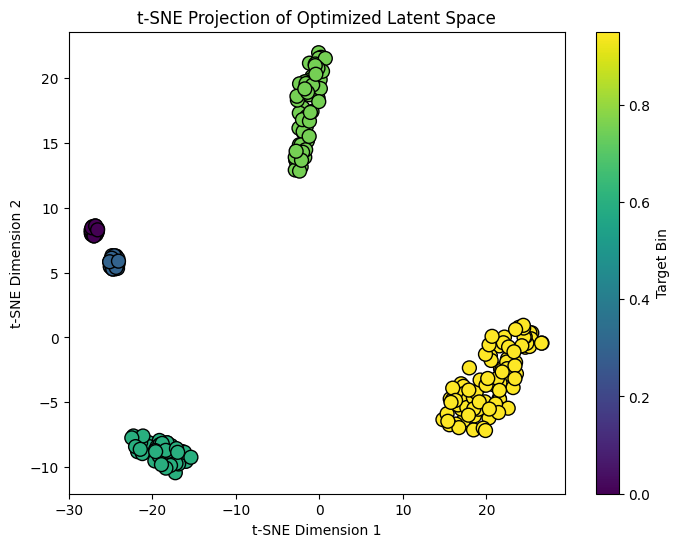

In [ ]:
# Ok, lets do t-SNE between emb column and bin column
from sklearn.manifold import TSNE

# Convert optimized latents to numpy arrays
mu_np = means
targets_np = bins

# Apply t-SNE for 2D projection
print(mu_np.shape)
tsne = TSNE(n_components=2, random_state=42, perplexity = 25)
latent_2d = tsne.fit_transform(mu_np)

# Create plot with color coding by target means
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=targets_np, cmap='viridis',
                      s=100, edgecolor='black')

# Add labels and colorbar
plt.colorbar(scatter, label='Target Bin')
plt.title('t-SNE Projection of Optimized Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Annotate points with their target means
# for i, (x, y) in enumerate(latent_2d):
#     plt.text(x, y, f'{targets_np[i]:.1f}',
#              ha='center', va='bottom', fontweight='bold')

plt.show()

In [ ]:
valid_batch = next(iter(valid_dl))

In [ ]:
valid_means = model(valid_batch[0].to(device))[0].cpu().detach().numpy()
valid_bins = valid_batch[1].numpy()

(23, 64)


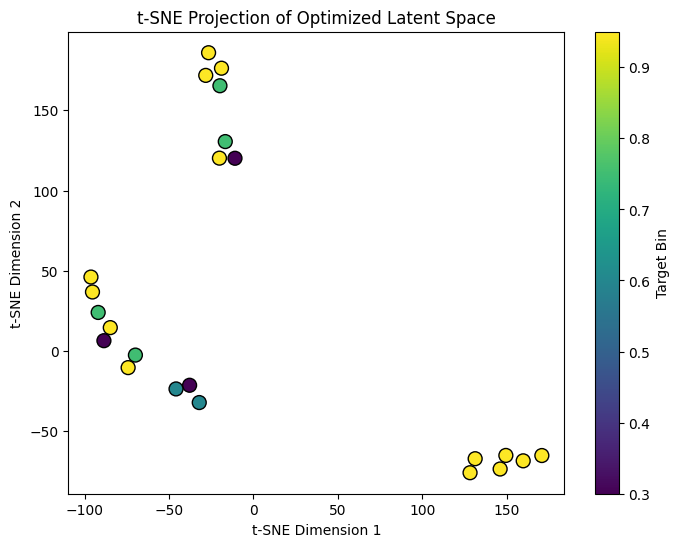

In [ ]:
# Ok, lets do t-SNE between emb column and bin column
from sklearn.manifold import TSNE

# Convert optimized latents to numpy arrays
mu_np = valid_means
targets_np = valid_bins

# Apply t-SNE for 2D projection
print(mu_np.shape)
tsne = TSNE(n_components=2, random_state=42, perplexity = 3)
latent_2d = tsne.fit_transform(mu_np)

# Create plot with color coding by target means
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=targets_np, cmap='viridis',
                      s=100, edgecolor='black')

# Add labels and colorbar
plt.colorbar(scatter, label='Target Bin')
plt.title('t-SNE Projection of Optimized Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Annotate points with their target means
# for i, (x, y) in enumerate(latent_2d):
#     plt.text(x, y, f'{targets_np[i]:.1f}',
#              ha='center', va='bottom', fontweight='bold')

plt.show()

# Prepare Dataset and Analysis

In [ ]:
# Analyse the histogram of Age Bins

In [ ]:
path = Path('/Users/pranaybindela/Desktop/sd/cryptonite/agedb')
image_paths = list(path.iterdir())

In [ ]:
len(image_paths)

16488

In [ ]:
def get_bin(age):
    bins = {
        range(1, 4): 0,
        range(4, 8): 1,
        range(8, 13): 2,
        range(13, 17): 3,
        range(18, 21): 4,
        range(21, 27): 5,
        range(27, 35): 6,
        range(35, 300): 7,
    }

    age = int(age)

    for k, v in bins.items():
        if age in k: return v
    return -1

In [ ]:
age_bins = [get_bin(int(p.name.split('.')[0].split('_')[-2])) for p in image_paths]

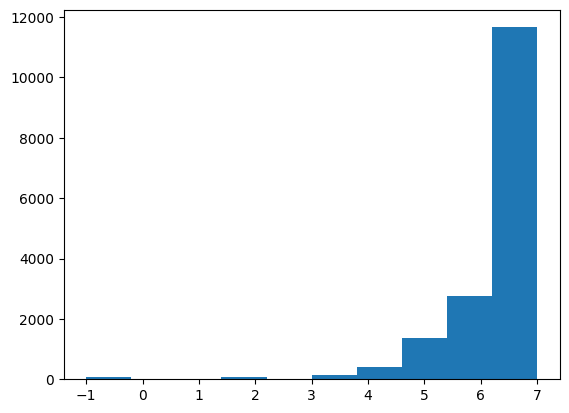

In [ ]:
plt.hist(age_bins)
plt.show()

**Swithching to MORPH2 Dataset - Due to bin imbalance**

In [ ]:
path = Path('/Users/pranaybindela/Desktop/sd/cryptonite/MORPH2')
train_image_paths = (path/'Images/Train').iterdir()

def get_bin(age):
    bins = {

        range(16, 22): '16-21',
        range(22, 27): '21-27',
        range(27, 35): '27-35',
        range(35, 300): '=>35',
    }

    age = int(age)

    for k, v in bins.items():
        if age in k: return v
    return 'None'

age_bins = []
for p in train_image_paths:
    age_bins.append(get_bin(int(p.name.split('.')[0][-2:])))

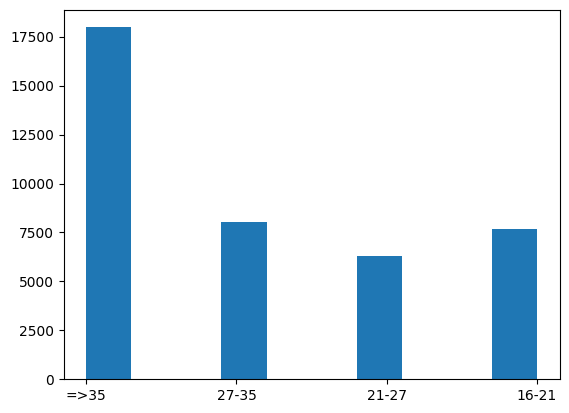

In [ ]:
plt.hist(age_bins)
plt.show()

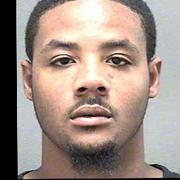

In [ ]:
img = Image.open(p)
img

In [ ]:
def facenet_preprocess(image_tensor: torch.Tensor) -> torch.Tensor:

    # image_tensor.shape = (bs, 3, height, width)

    # resize the image to 160, 160
    # normalize the image using mean = torch.Tensor([0.485, 0.456, 0.406]), std = torch.Tensor([0.229, 0.224, 0.225]).sqrt()


    # Step 1: Resize the image to 160x160.
    # F.interpolate expects a 4D tensor (N, C, H, W), so add a batch dimension.
    # image_tensor = image_tensor.unsqueeze(0)  # now shape is (1, 3, H, W)
    # image_tensor = F.interpolate(image_tensor, size=(160, 160), mode='bilinear', align_corners=False)
    # image_tensor = image_tensor.squeeze(0)      # back to (3, 160, 160)

    # Step 2: Normalize the image.
    # Note: The provided normalization uses std values after applying .sqrt() on them.
    mean = torch.tensor([0.485, 0.456, 0.406], device=image_tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=image_tensor.device).sqrt().view(1, 3, 1, 1)

    image_tensor = (image_tensor - mean) / std

    return image_tensor

In [ ]:
def create_processed_df(folder_path):
    device = torch.device('mps')
    resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

    results = []            # List to hold dictionaries for each image
    batch = []              # List to collect image tensors for the current batch
    info_batch = []         # List to collect metadata for the current batch
    batch_size = 32

    # Process all image paths from the folder
    image_paths = list(folder_path.iterdir())
    bc = 0

    for p in tqdm(image_paths):
        age = int(p.name.split('.')[0][-2:])
        bin_val = get_bin(age)

        if bin_val == "=>35": # Fixing the class Imbalance thing due to higher number of records with >= 35 category
            bc += 1
            if bc % 2 == 0:
                continue
            # if bc >= 50: break

        img = Image.open(p)
        img_tensor = transforms.ToTensor()(img).unsqueeze(0)
        img_tensor = img_tensor.float()
        img_tensor = F.interpolate(img_tensor, size=(160, 160), mode='bilinear', align_corners=False)
        batch.append(img_tensor)

        info_batch.append({'path': p, 'age': age, 'bin': bin_val})
        # When batch is full, process it
        if len(batch) == batch_size:

            # Convert the batch
            with torch.no_grad():
                batch_tensor = torch.cat(batch, dim=0).to(device)
                processed_batch = facenet_preprocess(batch_tensor)
                embeddings = resnet(processed_batch).cpu().numpy()

            # Add each result to the results list
            for info, emb in zip(info_batch, embeddings):
                info['embs'] = emb
                results.append(info)

            # Clear batch lists
            batch = []
            info_batch = []
            # break

    # print(len(batch))

    # Process any remaining images that didn't fill a complete batch
    if len(batch) >= 1:
        try:
            with torch.no_grad():
                batch_tensor = torch.cat(batch, dim=0).to(device)
                processed_batch = facenet_preprocess(batch_tensor)
                embeddings = resnet(processed_batch).cpu().numpy()
            for info, emb in zip(info_batch, embeddings):
                info['embs'] = emb
                results.append(info)
        except Exception as e:
            print(f"Error processing batch: {e}")

    # Convert the results list into a DataFrame
    df = pd.DataFrame(results)
    return df


In [ ]:
df = create_processed_df(path/'Images/Train')
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40012/40012 [01:52<00:00, 356.93it/s]


,path,age,bin,embs
0,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,43,=>35,"[0.048700005, -0.119688295, -0.0033327588, 0.0..."
1,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,36,=>35,"[-0.06620506, -0.0012022204, 0.0046214773, -0...."
2,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,28,27-35,"[0.0147678545, 0.062098708, 0.06731891, -0.001..."
3,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,23,21-27,"[0.07786711, -0.07410723, 0.03650985, -0.01567..."
4,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,25,21-27,"[-0.010176948, -0.06133887, -0.00049630867, -0..."


In [ ]:
len(df)

31022

In [ ]:
df.to_pickle(path/'processed_train_df.pkl')

In [ ]:
valid_df = create_processed_df(path/'Images/Validation')
print(len(valid_df))
valid_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:14<00:00, 345.92it/s]


3888


,path,age,bin,embs
0,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,33,27-35,"[0.02754519, 0.008729703, -0.06329806, -0.0452..."
1,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,49,=>35,"[0.02798364, -0.057730857, -0.017640883, 0.007..."
2,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,23,21-27,"[0.019080395, 0.012673735, -0.032433845, -0.02..."
3,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,23,21-27,"[0.07627098, 0.04367711, -0.00038197948, 0.013..."
4,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,27,27-35,"[0.04250946, 0.058875807, -0.030963516, -0.002..."


In [ ]:
valid_df.to_pickle(path/'processed_valid_df.pkl')

In [ ]:
df = pickle.load(open(path/'processed_train_df.pkl', 'rb'))
valid_df = pickle.load(open(path/'processed_valid_df.pkl', 'rb'))

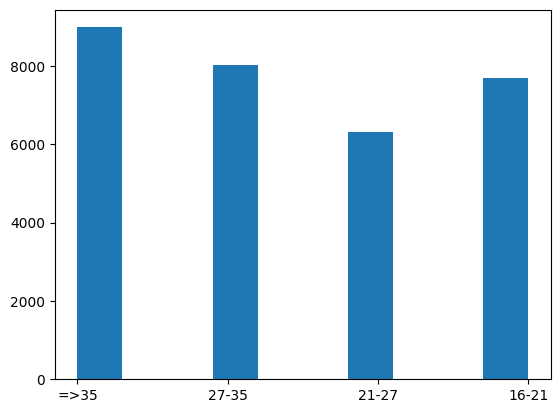

In [ ]:
plt.hist(df['bin'].values)
plt.show()

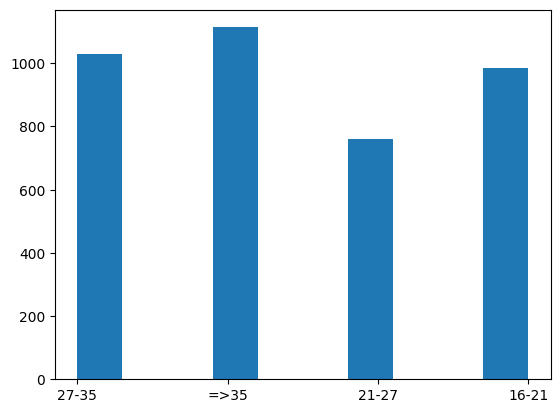

In [ ]:
plt.hist(valid_df['bin'].values)
plt.show()

# Lets Now Buld the model and train
Shifted to Colab hosted runtime, change of paths and device

In [ ]:
!pip install facenet_pytorch

In [2]:
train_df = pickle.load(open('/content/drive/MyDrive/cryotinite/processed_train_df.pkl', 'rb'))
valid_df = pickle.load(open('/content/drive/MyDrive/cryotinite/processed_valid_df.pkl', 'rb'))

In [3]:
train_df.head()

,path,age,bin,embs
0,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,43,=>35,"[0.048700005, -0.119688295, -0.0033327588, 0.0..."
1,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,36,=>35,"[-0.06620506, -0.0012022204, 0.0046214773, -0...."
2,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,28,27-35,"[0.0147678545, 0.062098708, 0.06731891, -0.001..."
3,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,23,21-27,"[0.07786711, -0.07410723, 0.03650985, -0.01567..."
4,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,25,21-27,"[-0.010176948, -0.06133887, -0.00049630867, -0..."


In [ ]:
valid_df.head()

,path,age,bin,embs
0,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,33,27-35,"[0.02754519, 0.008729703, -0.06329806, -0.0452..."
1,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,49,=>35,"[0.02798364, -0.057730857, -0.017640883, 0.007..."
2,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,23,21-27,"[0.019080395, 0.012673735, -0.032433845, -0.02..."
3,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,23,21-27,"[0.07627098, 0.04367711, -0.00038197948, 0.013..."
4,/Users/pranaybindela/Desktop/sd/cryptonite/MOR...,27,27-35,"[0.04250946, 0.058875807, -0.030963516, -0.002..."


In [4]:
mtcnn = MTCNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
print(f'Running on device: {device}')

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2', device = device).eval()

Running on device: cpu


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [5]:
class EmbDS(Dataset):

    def __init__(self, df, means = []):
        '''
            bins = {

                range(16, 22): '16-21', --> -0.7
                range(22, 27): '21-27', --> 0.0
                range(27, 35): '27-35', --> 0.45
                range(35, 300): '=>35', --> 0.9
            }
        '''
        self.means = {
            '16-21': -0.7,
            '21-27': 0.0,
            '27-35': 0.45,
            '=>35': 0.9
        }

        if means != [] and len(means) == 4:
            for (k, v), m in zip(self.means.items(), means):
                self.means[k] = m

        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        bin_id = row['bin'].strip()

        emb = torch.Tensor(row['embs'])
        return emb, self.means[bin_id]


In [6]:
train_ds = EmbDS(train_df)
valid_ds = EmbDS(valid_df)

x_t, y_t = train_ds[0]
x_t.shape, y_t

(torch.Size([512]), 0.9)

In [7]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

train_iter = iter(train_dl)
batch = next(train_iter)

batch[0].shape, batch[1].shape

(torch.Size([32, 512]), torch.Size([32]))

In [8]:
def KLDivergenceLoss(mu, log_var, target_mu, target_var = torch.Tensor([0.6])):
    target_var = target_var.to(mu.device)
    kl_div = 0.5 * (
        (torch.log(target_var.unsqueeze(1)) - log_var) +
        (torch.exp(log_var) + (mu - target_mu.unsqueeze(1))**2) / target_var.unsqueeze(1) -
        1.0
    )

    loss = kl_div.sum(dim=1).mean()
    return loss

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    def __init__(self, input_dim, output_dim, norm = False):
        super().__init__()

        layers = []
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        layers.append(nn.ReLU())
        layers.append(nn.Linear(input_dim, output_dim))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class IDBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        if input_dim != output_dim:
            self.down_lin = nn.Linear(input_dim, output_dim)
        else:
            self.down_lin = None

    def forward(self, x):
        if self.down_lin:
            return self.down_lin(x)
        else:
            return x


class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm = False):
        super().__init__()
        self.down_lin = IDBlock(input_dim, output_dim)
        self.b1 = PreActBlock(output_dim, output_dim, norm = norm)
        self.b2 = PreActBlock(output_dim, output_dim, norm = norm)

    def forward(self, x):
        down = self.down_lin(x)
        out = self.b1(down)
        out = self.b2(out)
        return down + out

class EmbTransform(nn.Module):
    def __init__(self):
        super(EmbTransform, self).__init__()
        self.l1 = ResBlock(512, 256, norm = True)
        self.l2 = ResBlock(256, 256, norm = True)
        self.l2_5 = ResBlock(256, 256, norm = True)
        self.l3 = ResBlock(256, 128, norm = True)
        self.l3_5 = ResBlock(128, 128, norm = True)
        self.l4 = PreActBlock(128, 128, norm = False)
        self.l4_5 = PreActBlock(128, 128, norm = False)
        self.l5 = PreActBlock(128, 128, norm = False)

    def forward(self, x):
        x = self.l1(x)

        x = self.l2(x)
        x = self.l2_5(x)
        x = self.l3(x)
        x = self.l3_5(x)
        x = self.l4(x)
        x = self.l4_5(x)
        x = self.l5(x)
        mu, log_var = x[:, :64], x[:, 64:]
        return mu, log_var

In [ ]:
epochs = 1000

train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True)

model = EmbTransform()
model = model.to(device)

opt = AdamW(model.parameters(), lr = 1e-02, weight_decay = 0.3)

max_lr = 5e-04
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.1,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.85,
                                                   max_momentum=0.95,
                                                   div_factor=100.0,
                                                   final_div_factor=1000,
                                                   last_epoch=-1)

# variances = np.linspace(0.05, 0.15, epochs)
train_losses = []
valid_losses = []
for epoch in range(epochs):
    train_iter = iter(train_dl)
    for it, (x, y) in enumerate(train_iter):
        x = x.to(device) + torch.randn_like(x).to(device) * 0.1#variances[epoch]
        y = y.to(torch.float32).to(device)
        mu_pred, log_var_pred = model(x)
        loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.5]))

        train_losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    valid_iter = iter(valid_dl)

    for it, (x, y) in enumerate(valid_iter):
        x = x.to(device)
        y = y.to(torch.float32).to(device)

        with torch.no_grad():
            mu_pred, log_var_pred = model(x)
            loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.5]))
            valid_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Train Loss: {np.mean(train_losses[-len(train_dl):]):.4f} | Valid Loss: {np.mean(valid_losses[-len(valid_dl):]):.4f}")

In [ ]:
lr_scheduler.get_lr()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1761: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[5.005949499461019e-09]

In [ ]:
epochs = 1000
max_lr = 1e-06
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
#                                                    max_lr,
#                                                    epochs=epochs,
#                                                    steps_per_epoch=len(train_dl),
#                                                    pct_start=0.1,
#                                                    anneal_strategy='cos',
#                                                    cycle_momentum=True,
#                                                    base_momentum=0.5,
#                                                    max_momentum=0.85,
#                                                    div_factor=25.0,
#                                                    final_div_factor=100,
#                                                    last_epoch=-1)

opt = torch.optim.SGD(model.parameters(), lr = max_lr, weight_decay = 0.8)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                          T_max=len(train_dl)*epochs,
                                                          eta_min = 1e-07)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    train_iter = iter(train_dl)
    for it, (x, y) in enumerate(train_iter):
        x = x.to(device) + torch.randn_like(x).to(device) * 0.1
        y = y.to(torch.float32).to(device)
        mu_pred, log_var_pred = model(x)
        loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
        train_losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    valid_iter = iter(valid_dl)
    valid_losses = []
    for it, (x, y) in enumerate(valid_iter):
        x = x.to(device)
        y = y.to(torch.float32).to(device)

        with torch.no_grad():
            mu_pred, log_var_pred = model(x)
            loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
            valid_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Train Loss: {np.mean(train_losses[-len(train_dl):]):.4f} | Valid Loss: {np.mean(valid_losses[-len(valid_dl):]):.4f}")

Epoch: 0 | Train Loss: 5.9488 | Valid Loss: 5.3515
Epoch: 5 | Train Loss: 5.8400 | Valid Loss: 5.2975
Epoch: 10 | Train Loss: 5.8077 | Valid Loss: 5.2860
Epoch: 15 | Train Loss: 5.7953 | Valid Loss: 5.2967
Epoch: 20 | Train Loss: 5.8197 | Valid Loss: 5.2413
Epoch: 25 | Train Loss: 5.7809 | Valid Loss: 5.2151
Epoch: 30 | Train Loss: 5.7170 | Valid Loss: 5.2472
Epoch: 35 | Train Loss: 5.7675 | Valid Loss: 5.1770
Epoch: 40 | Train Loss: 5.7024 | Valid Loss: 5.1212
Epoch: 45 | Train Loss: 5.6597 | Valid Loss: 5.1020
Epoch: 50 | Train Loss: 5.6096 | Valid Loss: 5.1076
Epoch: 55 | Train Loss: 5.6064 | Valid Loss: 5.0659
Epoch: 60 | Train Loss: 5.6778 | Valid Loss: 5.0795
Epoch: 65 | Train Loss: 5.6025 | Valid Loss: 5.0865
Epoch: 70 | Train Loss: 5.5498 | Valid Loss: 5.0201
Epoch: 75 | Train Loss: 5.5592 | Valid Loss: 5.0215
Epoch: 80 | Train Loss: 5.5341 | Valid Loss: 5.0053
Epoch: 85 | Train Loss: 5.6240 | Valid Loss: 4.9461
Epoch: 90 | Train Loss: 5.5006 | Valid Loss: 5.0296
Epoch: 95 | Tr

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/cryotinite/model.pt")

In [ ]:
model = EmbTransform()
model.load_state_dict(torch.load("/content/drive/MyDrive/cryotinite/model.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
x, y = next(train_iter)
x = x.to(device)
y = y.to(torch.float32).to(device)
mu_pred, log_var_pred = model(x)
mean_loss = ((mu_pred - y.unsqueeze(1))**2).mean()
mean_loss

In [ ]:
def modified_KLDivergenceLoss(mu, log_var, target_mu, target_var=torch.Tensor([0.6]), gamma=10.0):

    # target_var = target_var.to(mu.device)

    # # KL divergence between two Gaussians:
    # # D_KL(N(mu, sigma^2) || N(target_mu, target_var))
    # kl_div = 0.5 * (
    #     (torch.log(target_var.unsqueeze(0)) - log_var) +
    #     (torch.exp(log_var) + (mu - target_mu.unsqueeze(0))**2) / target_var.unsqueeze(0) -
    #     1.0
    # )
    # kl_loss = kl_div.sum(dim=1).mean()

    target_var = target_var.to(mu.device)
    kl_div = 0.5 * (
        (torch.log(target_var.unsqueeze(1)) - log_var) +
        (torch.exp(log_var) + (mu - target_mu.unsqueeze(1))**2) / target_var.unsqueeze(1) -
        1.0
    )

    kl_loss = kl_div.sum(dim=1).mean()

    # Additional mean penalty (L2 loss) to force the means toward target_mu.
    mean_loss = ((mu - target_mu.unsqueeze(1))**2).mean()
    total_loss = kl_loss + gamma * mean_loss
    return total_loss, kl_loss, mean_loss


In [ ]:
epochs = 2000

train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True)

model = EmbTransform()
model = model.to(device)

opt = AdamW(model.parameters(), lr = 1e-02, weight_decay = 0.8)

max_lr = 1e-04
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.1,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.85,
                                                   max_momentum=0.95,
                                                   div_factor=100.0,
                                                   final_div_factor=1000,
                                                   last_epoch=-1)


train_losses = []
train_kl_losses = []
train_mean_losses = []
valid_losses = []
valid_kl_losses = []
valid_mean_losses = []


for epoch in range(epochs):
    train_iter = iter(train_dl)
    for it, (x, y) in enumerate(train_iter):
        x = x.to(device) + torch.randn_like(x).to(device) * 0.1
        y = y.to(torch.float32).to(device)
        mu_pred, log_var_pred = model(x)
        # loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
        total_loss, kl_loss, mean_loss = modified_KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]), gamma = 20.0)

        train_losses.append(total_loss.cpu().item())
        train_kl_losses.append(kl_loss.cpu().item())
        train_mean_losses.append(mean_loss.cpu().item())

        opt.zero_grad()
        total_loss.backward()
        opt.step()
        lr_scheduler.step()

    valid_iter = iter(valid_dl)
    valid_losses = []
    for it, (x, y) in enumerate(valid_iter):
        x = x.to(device)
        y = y.to(torch.float32).to(device)

        with torch.no_grad():
            mu_pred, log_var_pred = model(x)
            # loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
            total_loss, kl_loss, mean_loss = modified_KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]), gamma = 10.0)

            valid_losses.append(total_loss.cpu().item())
            valid_kl_losses.append(kl_loss.cpu().item())
            valid_mean_losses.append(mean_loss.cpu().item())

    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | TL: {np.mean(train_losses[-len(train_dl):]):.4f} | \
        TKL: {np.mean(train_kl_losses[-len(train_dl):]):.4f} |\
        TML: {np.mean(train_mean_losses[-len(train_dl):]):.4f} |\
        VL: {np.mean(valid_losses[-len(train_dl):]):.4f} |\
        VKL: {np.mean(valid_kl_losses[-len(train_dl):]):.4f} |\
        VML: {np.mean(valid_mean_losses[-len(valid_dl):]):.4f}\
        ")

Epoch: 0 | TL: 27.1620 |         TKL: 19.0021 |        TML: 0.4080 |        VL: 23.2447 |        VKL: 19.1334 |        VML: 0.4111        
Epoch: 5 | TL: 27.2737 |         TKL: 19.0731 |        TML: 0.4100 |        VL: 23.1273 |        VKL: 19.0901 |        VML: 0.4092        
Epoch: 10 | TL: 26.9869 |         TKL: 18.8723 |        TML: 0.4057 |        VL: 23.0565 |        VKL: 18.9922 |        VML: 0.4082        
Epoch: 15 | TL: 26.8887 |         TKL: 18.7987 |        TML: 0.4045 |        VL: 22.9357 |        VKL: 18.8735 |        VML: 0.4063        
Epoch: 20 | TL: 26.7042 |         TKL: 18.6644 |        TML: 0.4020 |        VL: 22.6537 |        VKL: 18.6656 |        VML: 0.4015        
Epoch: 25 | TL: 26.4652 |         TKL: 18.4873 |        TML: 0.3989 |        VL: 22.3560 |        VKL: 18.4437 |        VML: 0.3967        
Epoch: 30 | TL: 25.5740 |         TKL: 17.8502 |        TML: 0.3862 |        VL: 21.1569 |        VKL: 17.5608 |        VML: 0.3758        
Epoch: 35 | TL: 22.841

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/cryotinite/model_2_9315.pt")

In [13]:
model = EmbTransform()
model.load_state_dict(torch.load("/content/drive/MyDrive/cryotinite/model_2_9315.pt", weights_only=True, map_location = 'cpu'))

<All keys matched successfully>

In [16]:
def show_tsne(mu_np, targets_np):

    # Apply t-SNE for 2D projection
    print(mu_np.shape)
    tsne = TSNE(n_components=2, random_state=42, perplexity = 25)
    latent_2d = tsne.fit_transform(mu_np)

    # Create plot with color coding by target means
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                        c=targets_np, cmap='viridis',
                        s=200, edgecolor='black')

    # Add labels and colorbar
    plt.colorbar(scatter, label='Target Bin')
    plt.title('t-SNE Projection of Optimized Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Annotate points with their target means
    # for i, (x, y) in enumerate(latent_2d):
    #     plt.text(x, y, f'{targets_np[i]:.1f}',
    #              ha='center', va='bottom', fontweight='bold')

    plt.show()

(2048, 64)


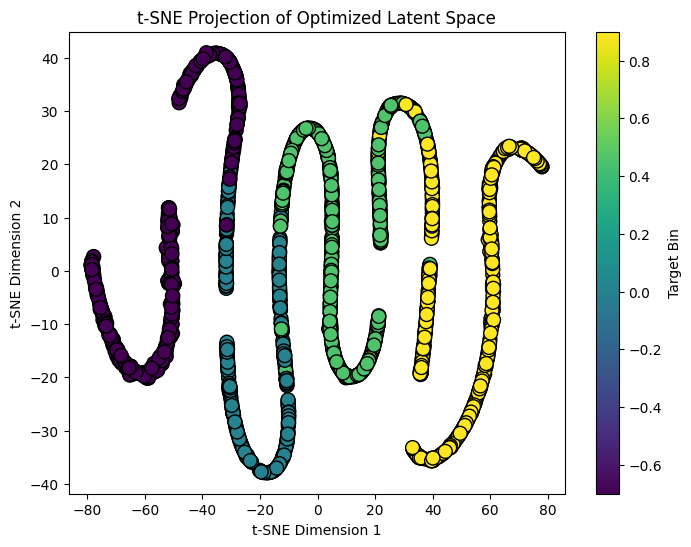

In [15]:
# Ok, lets do t-SNE between emb column and bin column
from sklearn.manifold import TSNE


model = model.to(device)
model.eval()
x, y = next(iter(train_dl))
x = x.to(device)
y = y.to(torch.float32).to(device)
mu_pred, log_var_pred = model(x)

# Convert optimized latents to numpy arrays
mu_np = mu_pred.cpu().detach().numpy()
targets_np = y.cpu().detach().numpy()
# targets_np = bins


show_tsne(mu_np, targets_np)

(3888, 64)


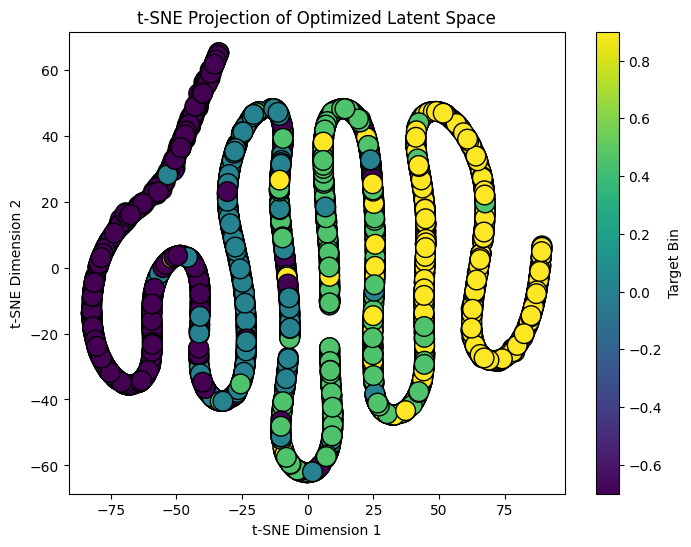

In [17]:
valid_dl = DataLoader(valid_ds, batch_size=4096, shuffle=True)
x, y = next(iter(valid_dl))
x = x.to(device)
y = y.to(torch.float32).to(device)
mu_pred, log_var_pred = model(x)

# Convert optimized latents to numpy arrays
mu_np = mu_pred.cpu().detach().numpy()
targets_np = y.cpu().detach().numpy()
# targets_np = bins


show_tsne(mu_np, targets_np)

# Bin Classification Model

In [27]:
class AgeRegressor(nn.Module):
    def __init__(self, transform_model_path = "/content/drive/MyDrive/cryotinite/model_2_9315.pt"):
        super().__init__()
        self.transform_model = EmbTransform()
        self.transform_model.load_state_dict(torch.load(transform_model_path, weights_only=True, map_location = device))

        self.transform_model.eval()

        self.lin1 = ResBlock(64, 32, norm = False)
        self.lin2 = ResBlock(32, 32, norm = False)
        self.lin3 = ResBlock(32, 16, norm = False)
        self.lin4 = ResBlock(16, 8, norm = False)
        self.lin5 = ResBlock(8, 1, norm = False)

    def forward(self, x):

        with torch.no_grad():
            mu_pred, log_var_pred = self.transform_model(x)

        x = self.lin1(mu_pred)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        x = self.lin5(x)
        return x

In [28]:
class RegressionDS(EmbDS):
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        age = float(row['age'])

        emb = torch.Tensor(row['embs'])
        return emb, age

In [38]:
#POC
train_ds = RegressionDS(train_df)
valid_ds = RegressionDS(valid_df)
#

train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True)
#

x, y = next(iter(train_dl))
x.shape, y.shape

model = AgeRegressor()
model = model.to(device)

for i in range(10):
    y = y.to(torch.float32).to(device)
    x = x.to(device)
    yhat = model(x)
    loss = F.mse_loss(yhat, y.unsqueeze(1))
    loss.backward()
    # breakpoint()
    for name, param in model.named_parameters():
        if param.grad == None: continue
        param.data -= 0.001 * param.grad.data
        param.grad.data = torch.zeros_like(param.grad.data)


    print(loss.item())

1062.2371826171875
1007.2642822265625
957.5357666015625
920.8574829101562
871.0111694335938
786.9393920898438
616.978271484375
250.51409912109375
733.8050537109375
959.8502197265625


In [39]:
epochs = 200
max_lr = 1e-02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AgeRegressor()
model = model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr = max_lr, weight_decay = 0.1)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.1,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.5,
                                                   max_momentum=0.85,
                                                   div_factor=25.0,
                                                   final_div_factor=100,
                                                   last_epoch=-1)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    train_iter = iter(train_dl)
    model.train()
    for it, (x, y) in enumerate(train_iter):
        x = x.to(device) + torch.randn_like(x).to(device) * 0.01
        y = y.to(torch.float32).to(device)
        yhat = model(x)
        # loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
        loss = F.mse_loss(yhat, y.unsqueeze(1))
        train_losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    valid_iter = iter(valid_dl)
    valid_losses = []
    model.eval()
    for it, (x, y) in enumerate(valid_iter):
        x = x.to(device)
        y = y.to(torch.float32).to(device)

        with torch.no_grad():
            yhat = model(x)
            # loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
            loss = F.mse_loss(yhat, y.unsqueeze(1))
            valid_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Train Loss: {np.mean(train_losses[-len(train_dl):]):.4f} | Valid Loss: {np.mean(valid_losses[-len(valid_dl):]):.4f}")

Epoch: 0 | Train Loss: 980.0802 | Valid Loss: 958.2209
Epoch: 5 | Train Loss: 60.7719 | Valid Loss: 65.8154
Epoch: 10 | Train Loss: 21.2281 | Valid Loss: 46.2794
Epoch: 15 | Train Loss: 14.6536 | Valid Loss: 24.2436
Epoch: 20 | Train Loss: 16.4144 | Valid Loss: 28.7644
Epoch: 25 | Train Loss: 16.4396 | Valid Loss: 22.0290
Epoch: 30 | Train Loss: 19.5789 | Valid Loss: 22.5138
Epoch: 35 | Train Loss: 29.2128 | Valid Loss: 21.7646
Epoch: 40 | Train Loss: 18.0553 | Valid Loss: 22.1835
Epoch: 45 | Train Loss: 15.1674 | Valid Loss: 22.5008
Epoch: 50 | Train Loss: 16.4131 | Valid Loss: 23.0728
Epoch: 55 | Train Loss: 15.6380 | Valid Loss: 21.9948
Epoch: 60 | Train Loss: 17.0049 | Valid Loss: 24.2260
Epoch: 65 | Train Loss: 14.9390 | Valid Loss: 33.8129
Epoch: 70 | Train Loss: 14.9497 | Valid Loss: 21.4466
Epoch: 75 | Train Loss: 14.2385 | Valid Loss: 21.1238
Epoch: 80 | Train Loss: 14.3444 | Valid Loss: 21.6523
Epoch: 85 | Train Loss: 14.5941 | Valid Loss: 21.5755
Epoch: 90 | Train Loss: 14.9

In [42]:
class AgeClassifier(AgeRegressor):
    def forward(self, x):
        x = super().forward(x)
        return F.sigmoid(x)

class ClassificationDS(EmbDS):
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        age = float(row['age'])
        label = 1 if age >= 21 else 0
        emb = torch.Tensor(row['embs'])
        return emb, label

In [47]:
#POC
train_ds = ClassificationDS(train_df)
valid_ds = ClassificationDS(valid_df)
#

train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True)
#

x, y = next(iter(train_dl))
x.shape, y.shape

model = AgeClassifier()
model = model.to(device)

for i in range(10):
    y = y.to(torch.float32).to(device)
    x = x.to(device)
    yhat = model(x)
    loss = F.binary_cross_entropy(yhat, y.unsqueeze(1))
    loss.backward()
    # breakpoint()
    for name, param in model.named_parameters():
        if param.grad == None: continue
        param.data -= 0.1 * param.grad.data
        param.grad.data = torch.zeros_like(param.grad.data)


    print(loss.item())

0.5413429737091064
0.5321443676948547
0.523335337638855
0.5151282548904419
0.50674968957901
0.49786919355392456
0.48821163177490234
0.4775943160057068
0.4655529856681824
0.4520278871059418


In [51]:
epochs = 200
max_lr = 1e-02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AgeClassifier()
model = model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr = max_lr, weight_decay = 0.8)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl),
                                                   pct_start=0.1,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.5,
                                                   max_momentum=0.85,
                                                   div_factor=25.0,
                                                   final_div_factor=100,
                                                   last_epoch=-1)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    train_iter = iter(train_dl)
    model.train()
    for it, (x, y) in enumerate(train_iter):
        x = x.to(device) + torch.randn_like(x).to(device) * 0.1
        y = y.to(torch.float32).to(device)
        yhat = model(x)
        # loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
        # loss = F.mse_loss(yhat, y.unsqueeze(1))
        loss = F.binary_cross_entropy(yhat, y.unsqueeze(1))
        train_losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    valid_iter = iter(valid_dl)
    valid_losses = []
    model.eval()
    for it, (x, y) in enumerate(valid_iter):
        x = x.to(device)
        y = y.to(torch.float32).to(device)

        with torch.no_grad():
            yhat = model(x)
            # loss = KLDivergenceLoss(mu_pred, log_var_pred, y, target_var = torch.Tensor([0.75]))
            loss = F.binary_cross_entropy(yhat, y.unsqueeze(1))
            valid_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Train Loss: {np.mean(train_losses[-len(train_dl):]):.4f} | Valid Loss: {np.mean(valid_losses[-len(valid_dl):]):.4f}")

Epoch: 0 | Train Loss: 0.5241 | Valid Loss: 0.4598
Epoch: 5 | Train Loss: 0.2277 | Valid Loss: 0.2136
Epoch: 10 | Train Loss: 0.2294 | Valid Loss: 0.2081
Epoch: 15 | Train Loss: 0.2285 | Valid Loss: 0.2231
Epoch: 20 | Train Loss: 0.2308 | Valid Loss: 0.2272
Epoch: 25 | Train Loss: 0.2309 | Valid Loss: 0.2191
Epoch: 30 | Train Loss: 0.2288 | Valid Loss: 0.2118
Epoch: 35 | Train Loss: 0.2282 | Valid Loss: 0.2256
Epoch: 40 | Train Loss: 0.2299 | Valid Loss: 0.2114
Epoch: 45 | Train Loss: 0.2336 | Valid Loss: 0.2278
Epoch: 50 | Train Loss: 0.2324 | Valid Loss: 0.2084
Epoch: 55 | Train Loss: 0.2308 | Valid Loss: 0.2188
Epoch: 60 | Train Loss: 0.2320 | Valid Loss: 0.2145
Epoch: 65 | Train Loss: 0.2319 | Valid Loss: 0.2221
Epoch: 70 | Train Loss: 0.2258 | Valid Loss: 0.2153
Epoch: 75 | Train Loss: 0.2222 | Valid Loss: 0.2073
Epoch: 80 | Train Loss: 0.2275 | Valid Loss: 0.2237
Epoch: 85 | Train Loss: 0.2320 | Valid Loss: 0.2103
Epoch: 90 | Train Loss: 0.2326 | Valid Loss: 0.2190
Epoch: 95 | Tr

In [57]:
def compute_metrics(yhat, y_target, threshold=0.5):
    """
    Computes accuracy, precision, and recall for binary classification.

    Args:
        yhat (torch.Tensor): Predicted probabilities, shape (N, 1)
        y_target (torch.Tensor): Ground truth labels (0 or 1), shape (N,)
        threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
        accuracy (float): Overall accuracy.
        precision (float): Precision metric.
        recall (float): Recall metric.
    """
    # Flatten yhat to shape (N,) and apply threshold
    y_pred = (yhat >= threshold).float().view(-1)
    y_true = y_target.float().view(-1)

    # Calculate true positives, false positives, true negatives, and false negatives
    TP = ((y_pred == 1) & (y_true == 1)).sum().item()
    TN = ((y_pred == 0) & (y_true == 0)).sum().item()
    FP = ((y_pred == 1) & (y_true == 0)).sum().item()
    FN = ((y_pred == 0) & (y_true == 1)).sum().item()

    # Compute the metrics
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    TNR = TN/(TN + FN) if (TN + FN) > 0 else 0.0
    FPR = FP/(FP + TN) if (FP + TN) > 0 else 0.0

    return accuracy, precision, recall, TNR, FPR

valid_dl = DataLoader(valid_ds, batch_size=4096, shuffle=True)
x, y = next(iter(valid_dl))
x = x.to(device)
y = y.to(torch.float32).to(device)
yhat = model(x)

accuracy, precision, recall, TNR, FPR = compute_metrics(yhat, y)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, TNR: {TNR:.4f}, FPR: {FPR:.4f}")

Accuracy: 0.9159, Precision: 0.9649, Recall: 0.9276, TNR: 0.7592, FPR: 0.1289


In [60]:
accuracy, precision, recall, TNR, FPR = compute_metrics(yhat, y, 0.7)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, TNR: {TNR:.4f}, FPR: {FPR:.4f}")

Accuracy: 0.9010, Precision: 0.9767, Recall: 0.8965, TNR: 0.6991, FPR: 0.0818
